BUSI Problem Set 2 

PART A - No skilled funds 
// Simulation of fund returns 
// Regres to estimate alphas, betas, and  t-statistics 
// Bootstrap to assess the distribution of the estimated alphas' t-statistics 
// Print relevant statistics & plot the distribution of the actual t-statistics

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

N = 1000 
T = 120
B = 100 
market_return_mean = 0.05 / 12 
market_return_sd = 0.2 / np.sqrt(12) 
residual_sd = 0.1 / np.sqrt(12) 

In [3]:
# 1 - Simulate market returns and fund returns
market_returns = np.random.normal(market_return_mean, market_return_sd, T)
funds_returns = np.zeros((N, T))
alphas = np.zeros(N)
betas = np.zeros(N)
t_stats = np.zeros(N)

for i in range(N):
    residuals = np.random.normal(0, residual_sd, T)
    fund_returns = market_returns + residuals  
    funds_returns[i, :] = fund_returns
    
    # Step 2: Regression 
    X = sm.add_constant(market_returns)  
    model = sm.OLS(fund_returns, X).fit()
    alphas[i] = model.params[0]
    betas[i] = model.params[1]
    t_stats[i] = model.tvalues[0]

mean_alpha = np.mean(alphas)
mean_beta = np.mean(betas)
mean_t_stat = np.mean(t_stats) 

print(f"Average Alpha: {mean_alpha:.4f}")
print(f"Average Beta: {mean_beta:.4f}")
print(f"Average T-Statistic for Alpha: {mean_t_stat:.4f}") 

Average Alpha: -0.0000
Average Beta: 1.0023
Average T-Statistic for Alpha: -0.0191


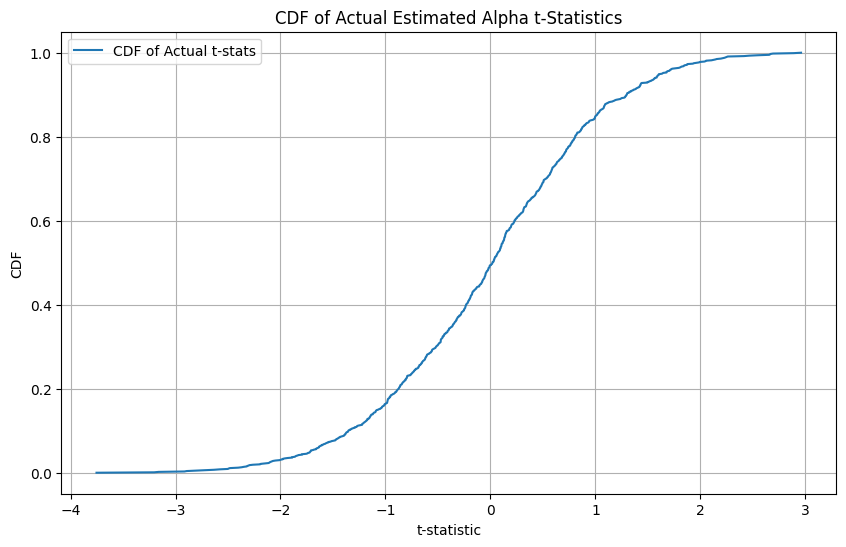

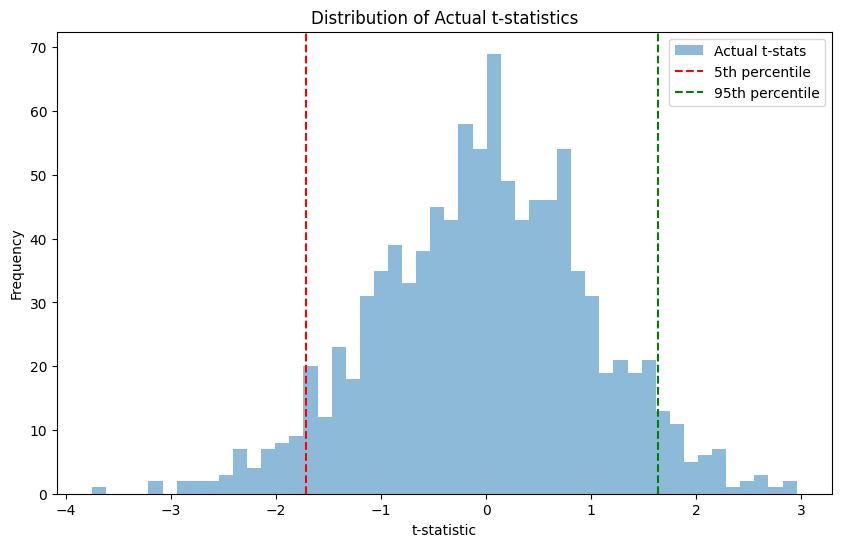

In [4]:
# 3 - Bootstrap 
bootstrap_t_stats = np.zeros((B, N))
for b in range(B):
    for i in range(N):
        bootstrap_sample = np.random.choice(T, size=T, replace=True)
        bootstrap_fund_returns = funds_returns[i, bootstrap_sample]
        X_bootstrap = sm.add_constant(market_returns[bootstrap_sample])
        model_bootstrap = sm.OLS(bootstrap_fund_returns, X_bootstrap).fit()
        bootstrap_t_stats[b, i] = model_bootstrap.tvalues[0]

sorted_t_stats = np.sort(t_stats)
cdf_actual = np.arange(1, N+1) / N

bootstrap_t_stats_sorted = np.sort(bootstrap_t_stats, axis=1)
bootstrap_cdf_mean = np.mean(np.arange(1, N+1) / N, axis=0)

# 4 - Plotting results for the actual t-statistics
plt.figure(figsize=(10, 6))
plt.plot(sorted_t_stats, cdf_actual, label='CDF of Actual t-stats')
plt.title('CDF of Actual Estimated Alpha t-Statistics')
plt.xlabel('t-statistic')
plt.ylabel('CDF')
plt.legend()
plt.grid(True)
plt.show()

# Plotting results for the bootstrap t-statistics
plt.figure(figsize=(10, 6))
plt.hist(t_stats, bins=50, alpha=0.5, label='Actual t-stats')
plt.axvline(x=np.percentile(t_stats, 5), color='r', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(t_stats, 95), color='g', linestyle='--', label='95th percentile')
plt.legend()
plt.xlabel('t-statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Actual t-statistics')
plt.show() 

PART 2 - Some skilled funds 

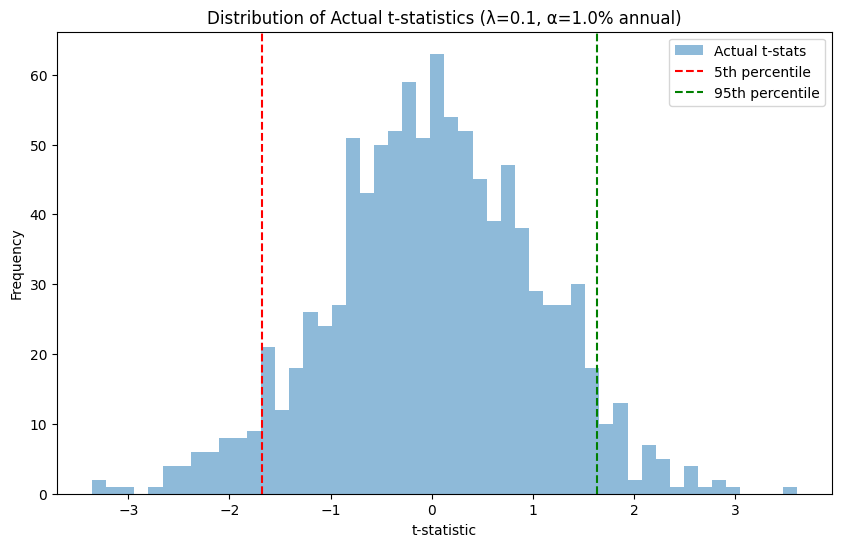

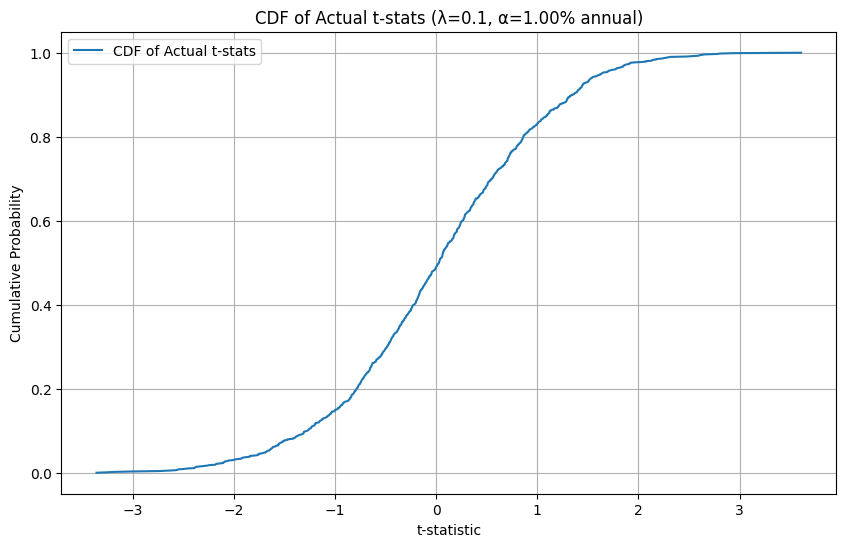

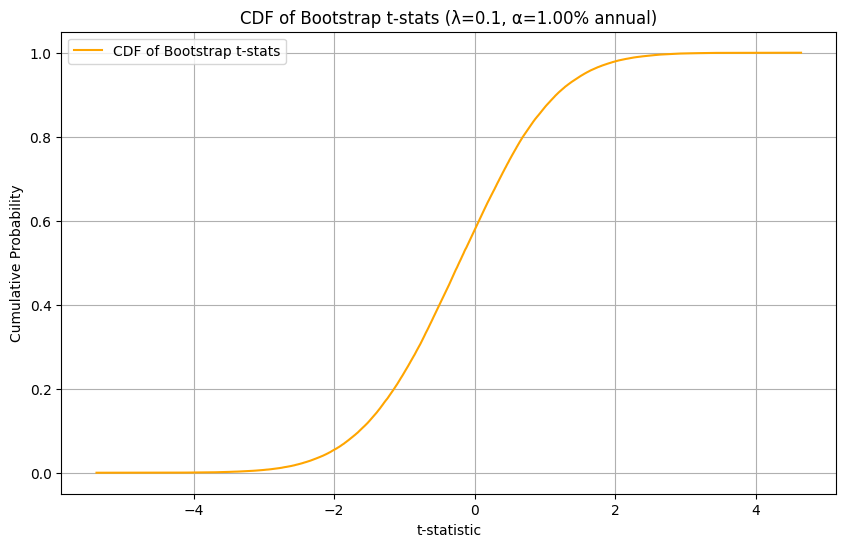

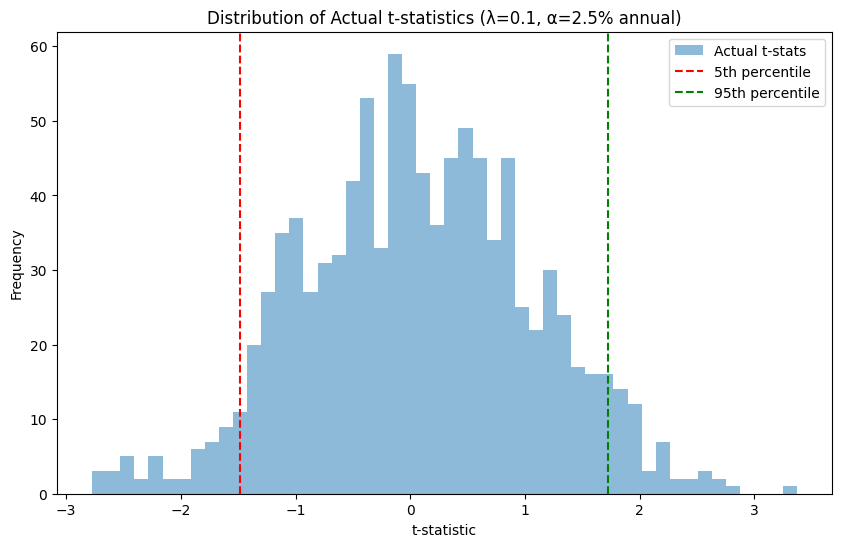

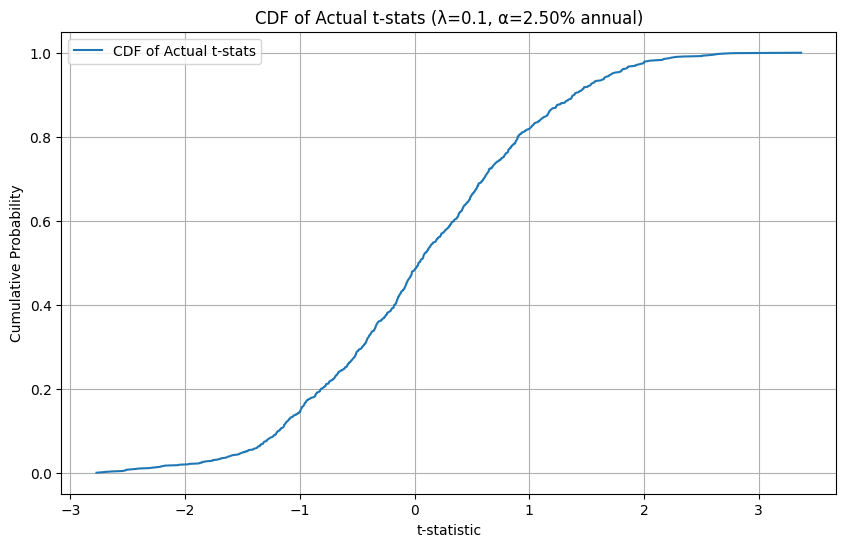

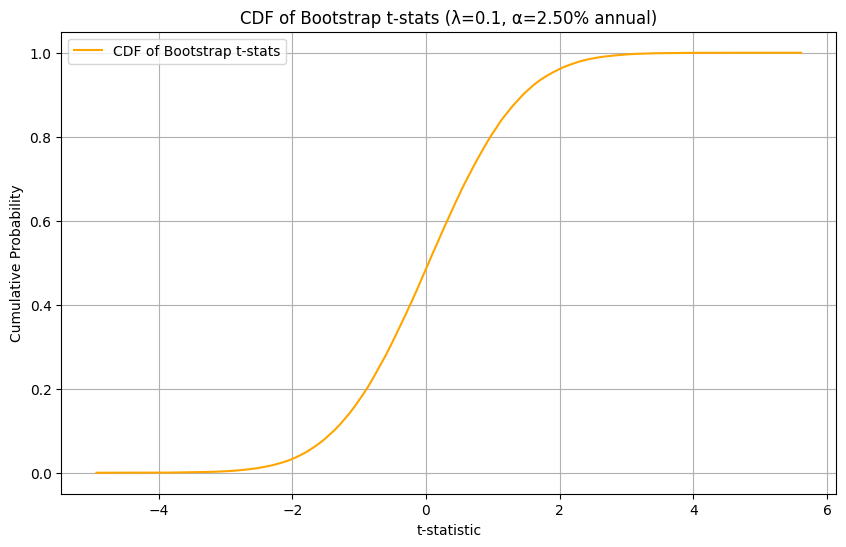

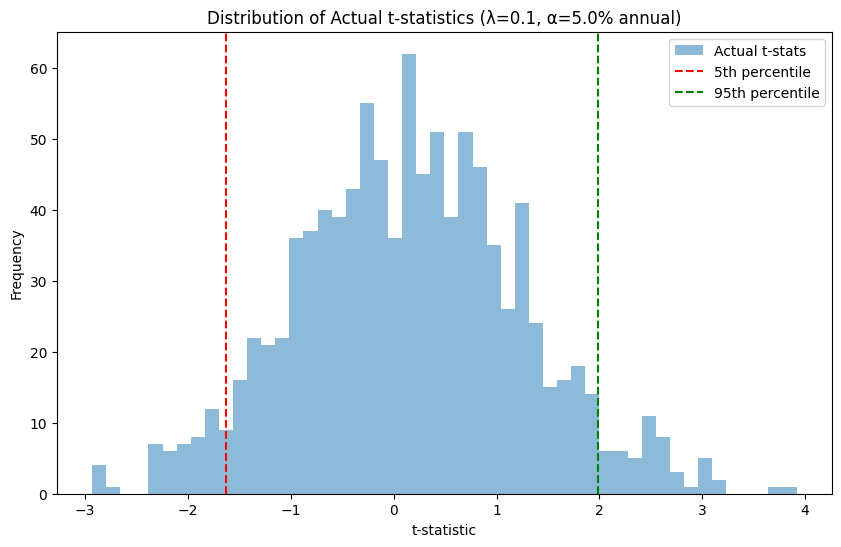

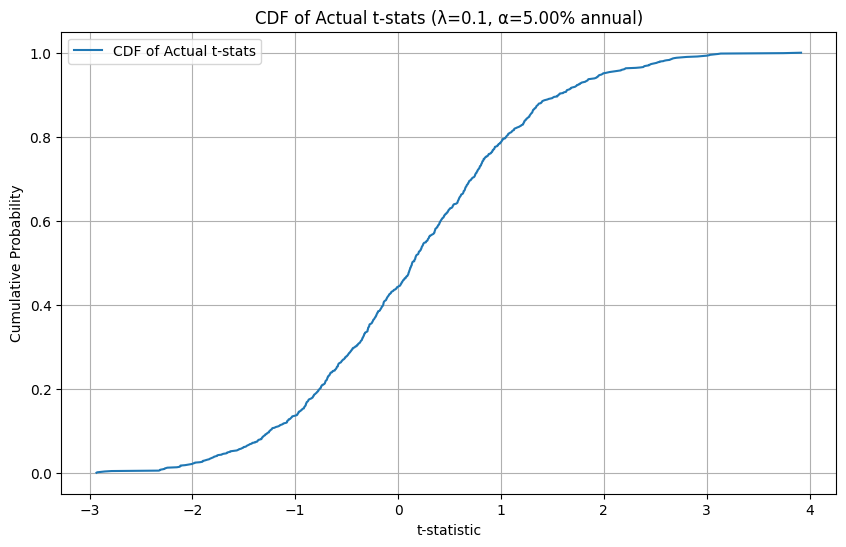

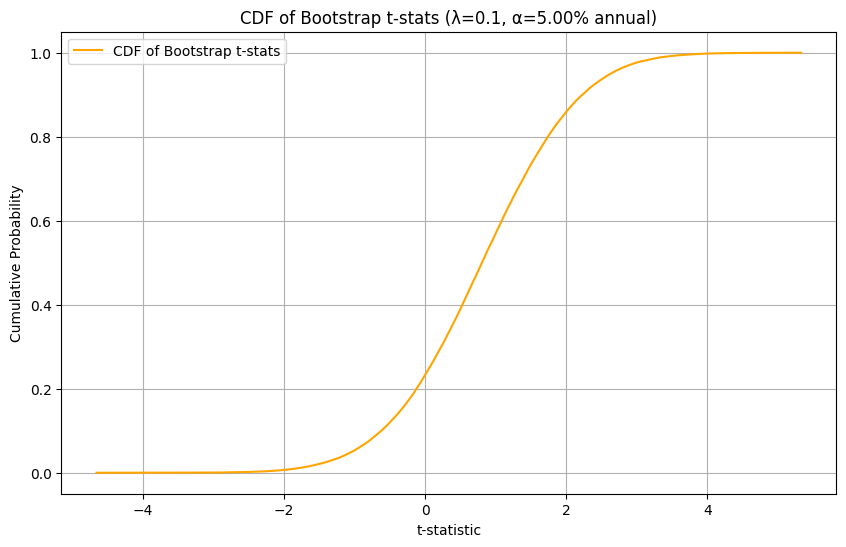

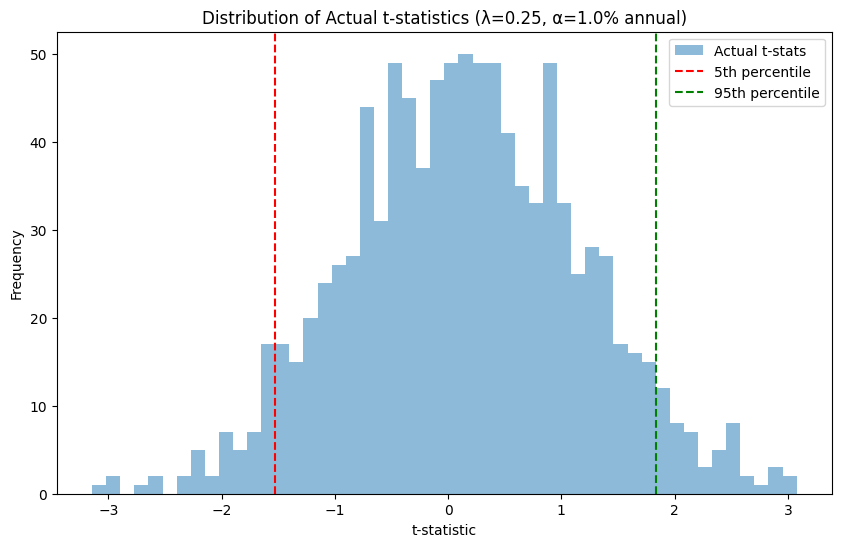

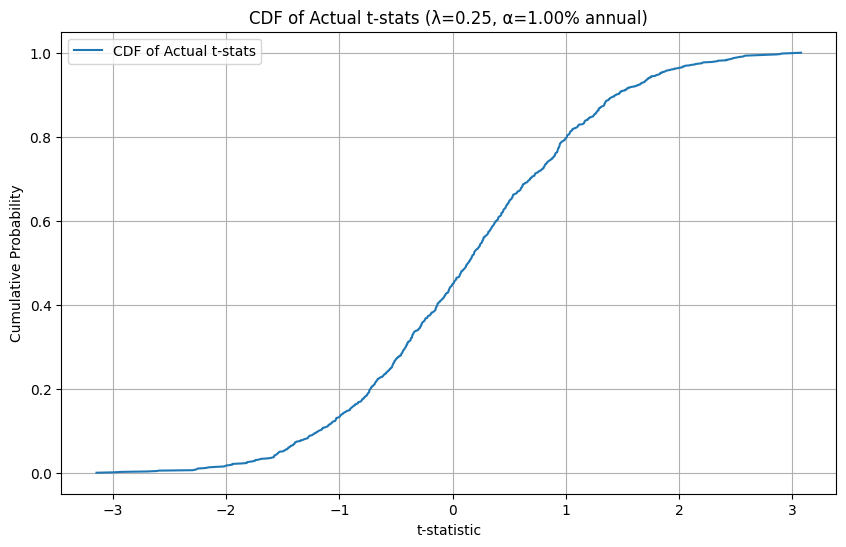

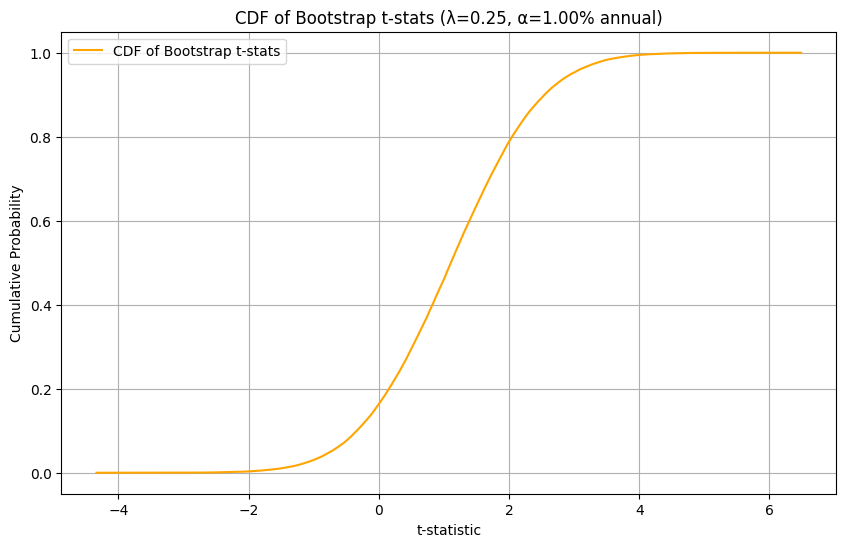

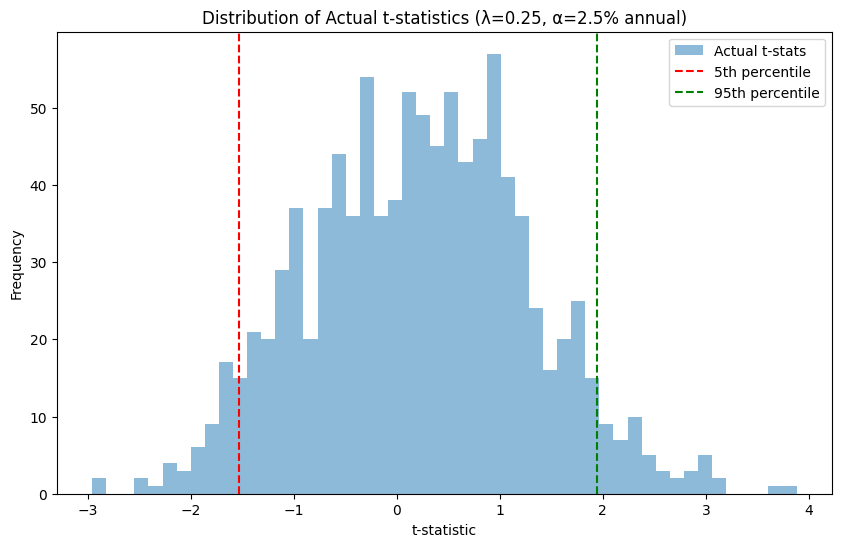

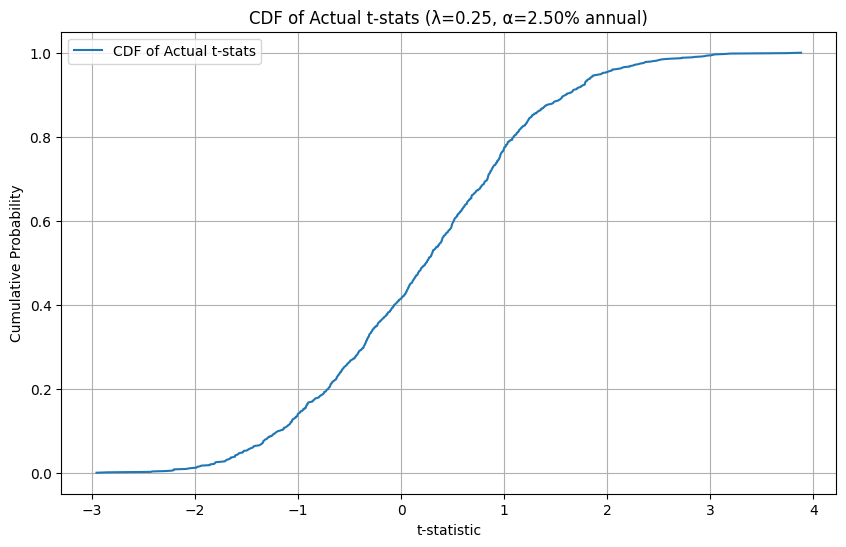

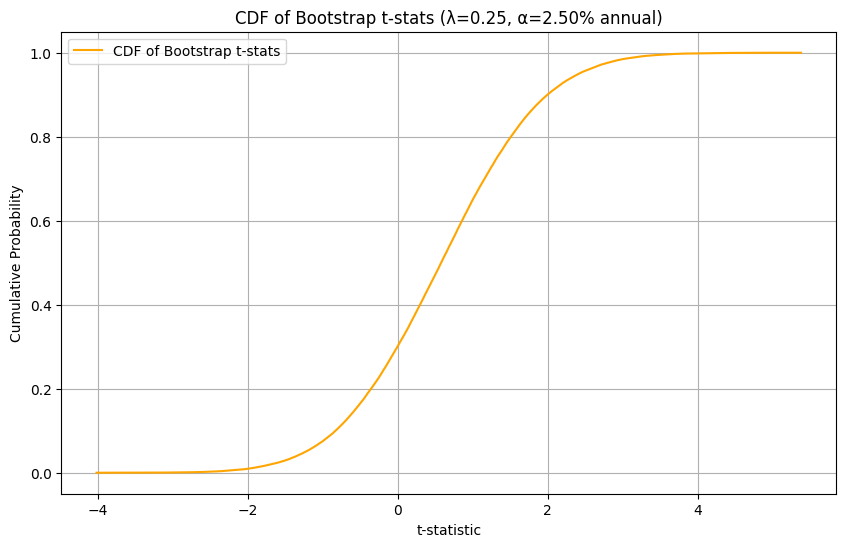

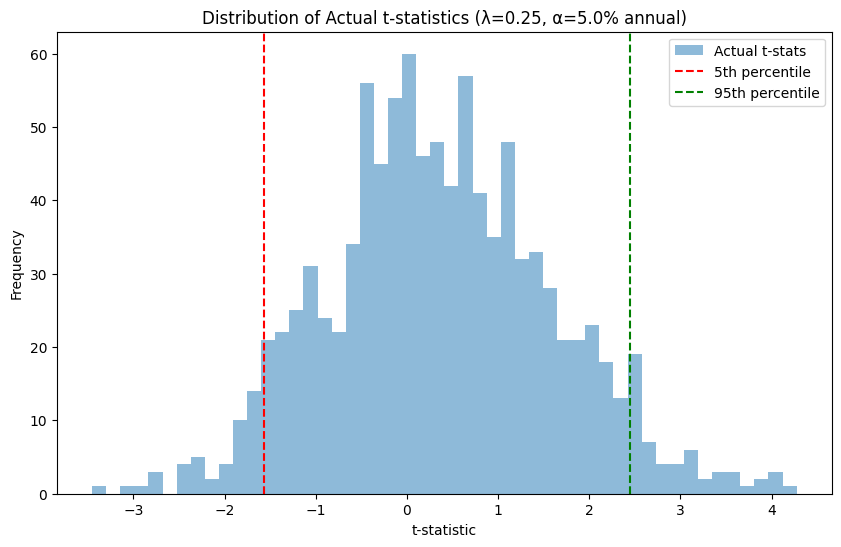

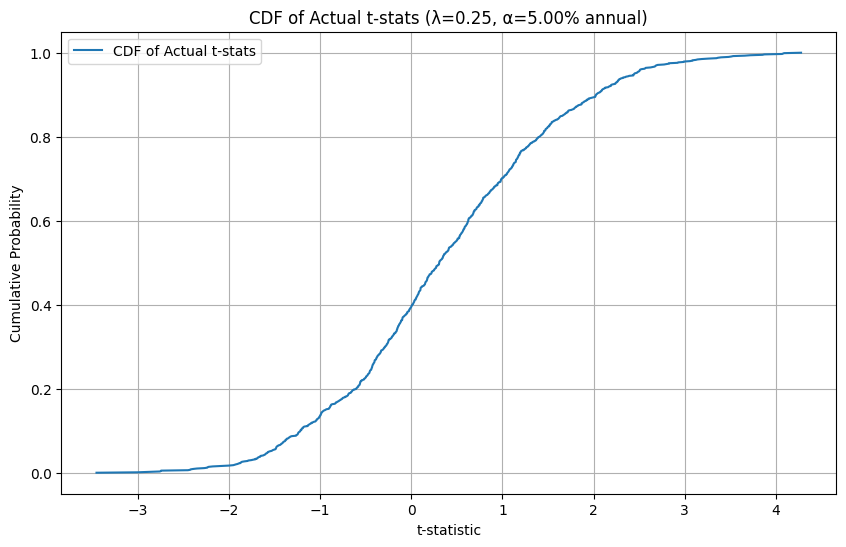

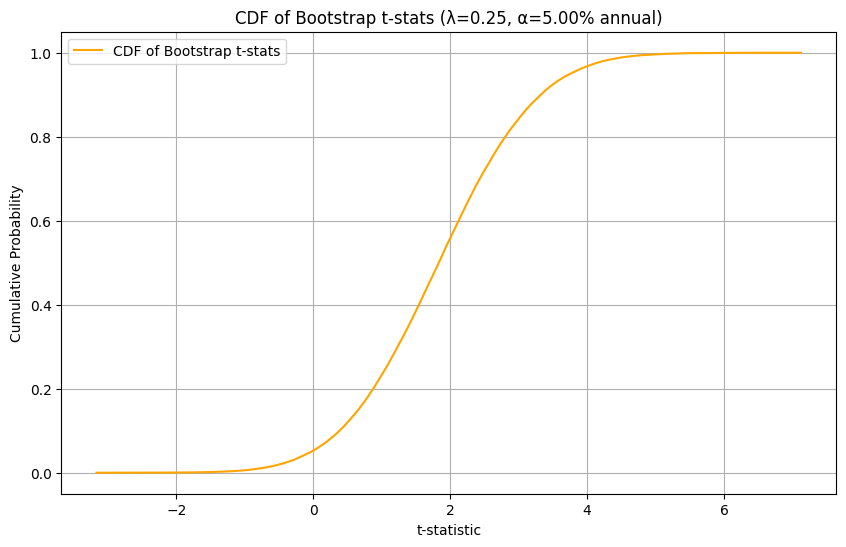

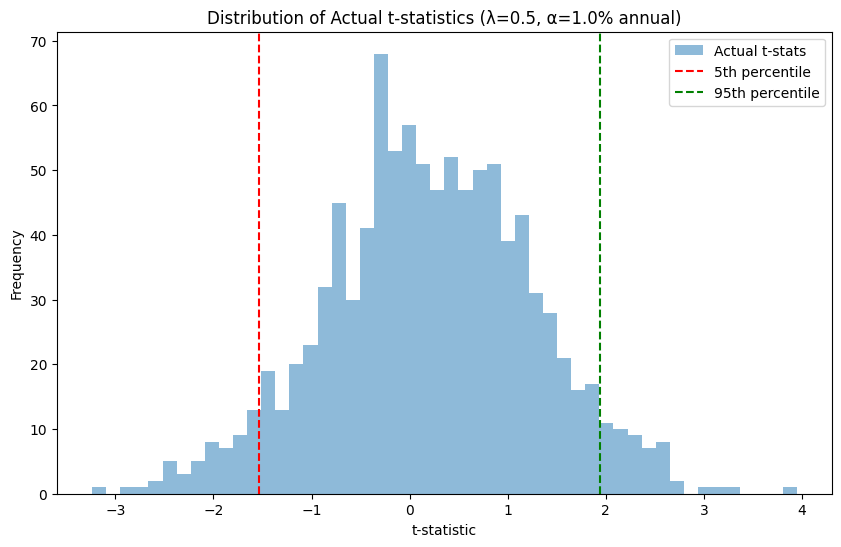

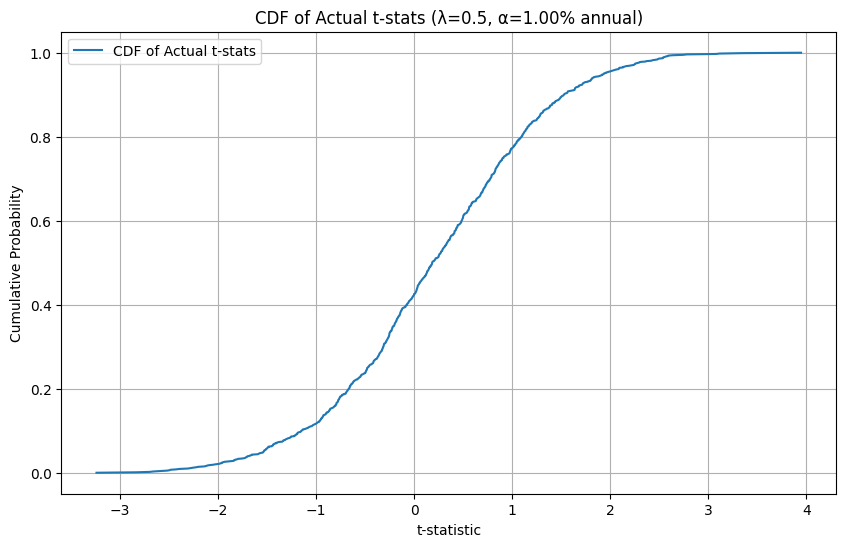

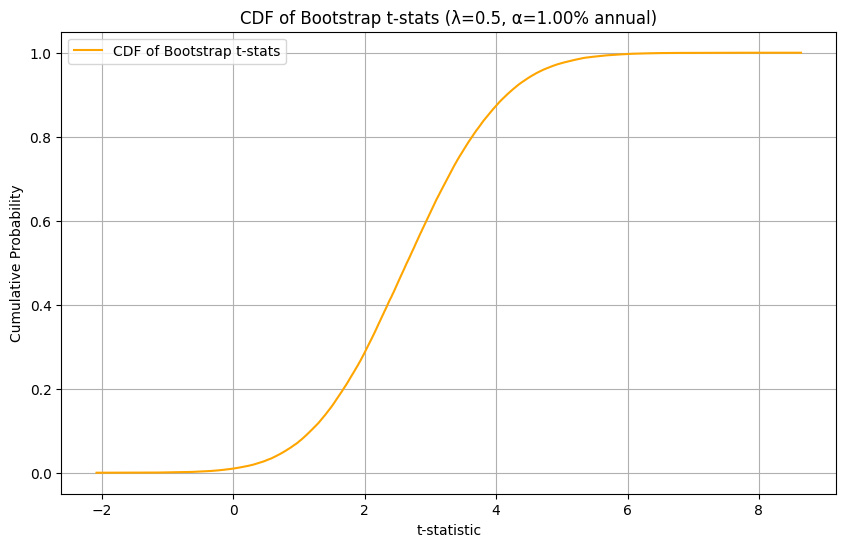

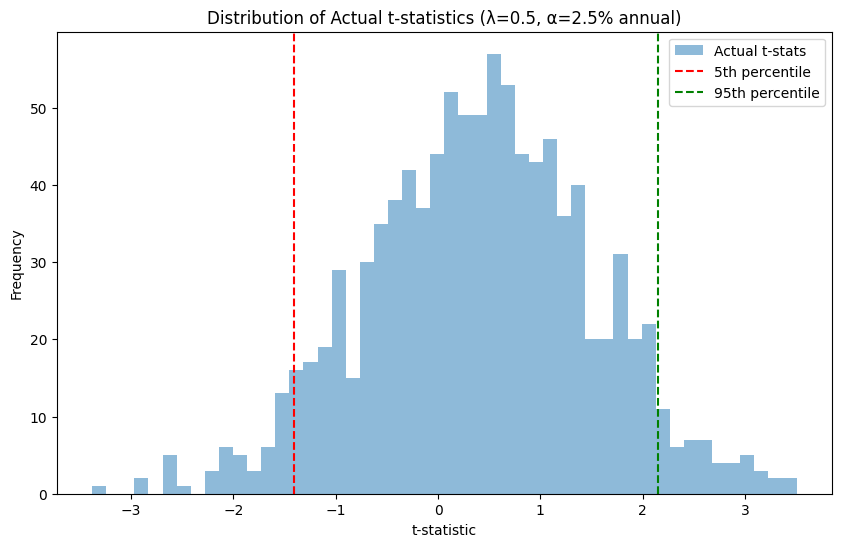

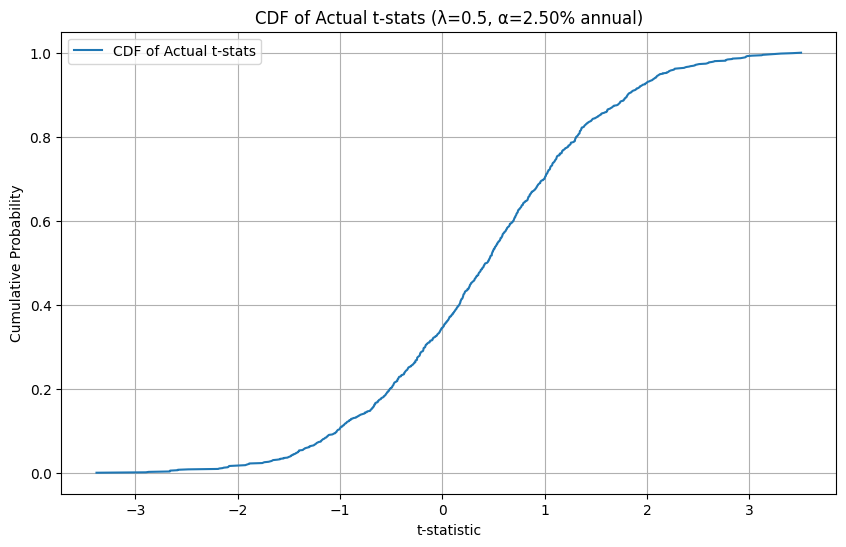

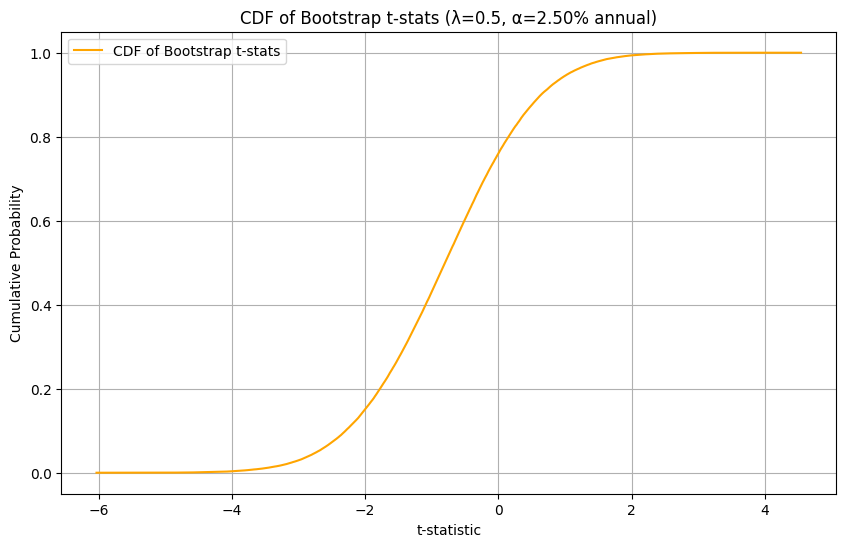

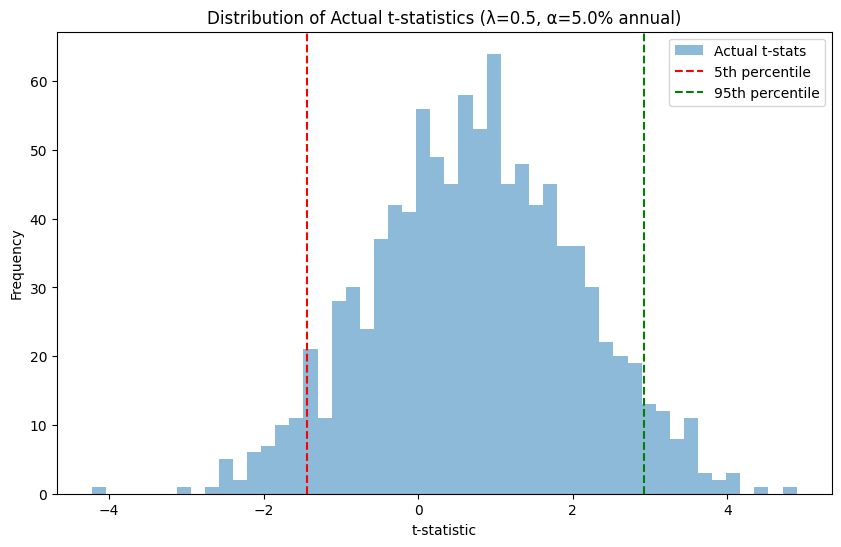

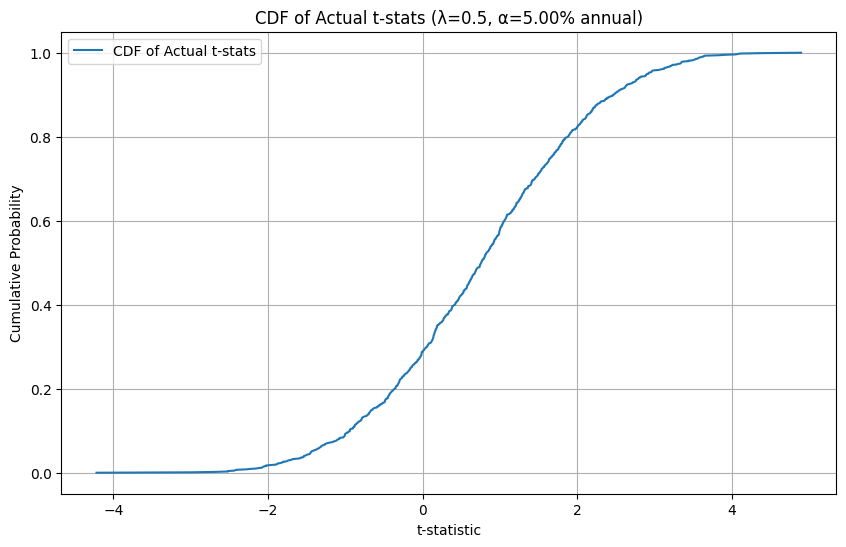

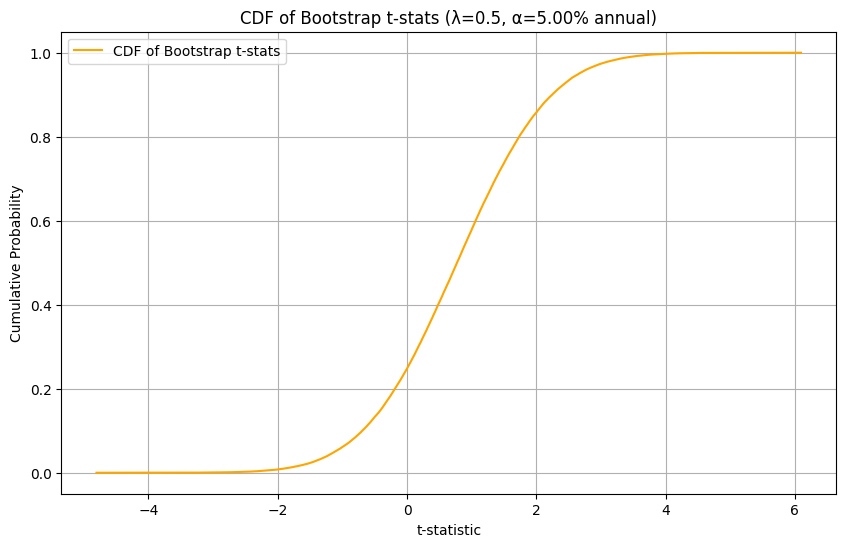

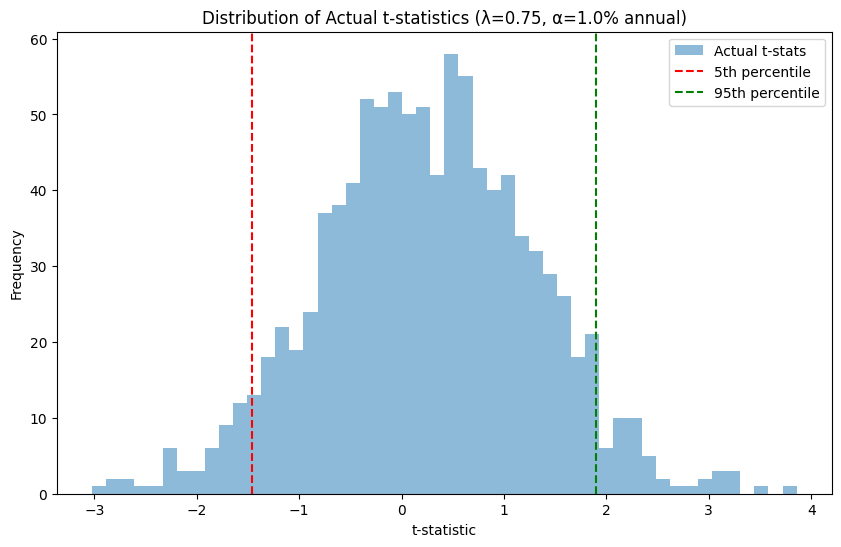

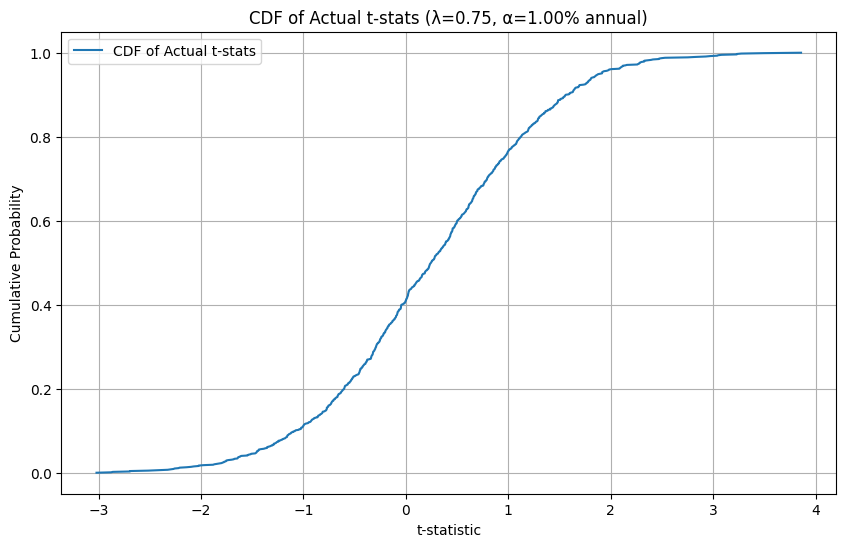

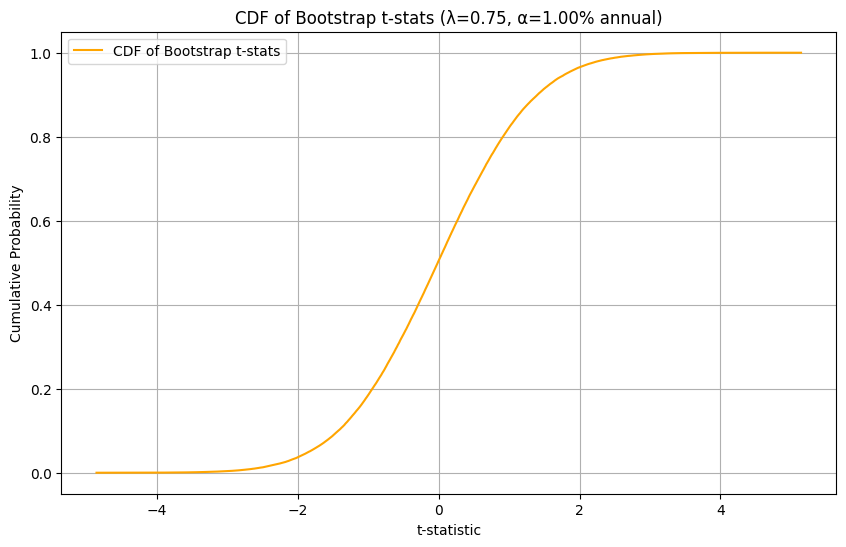

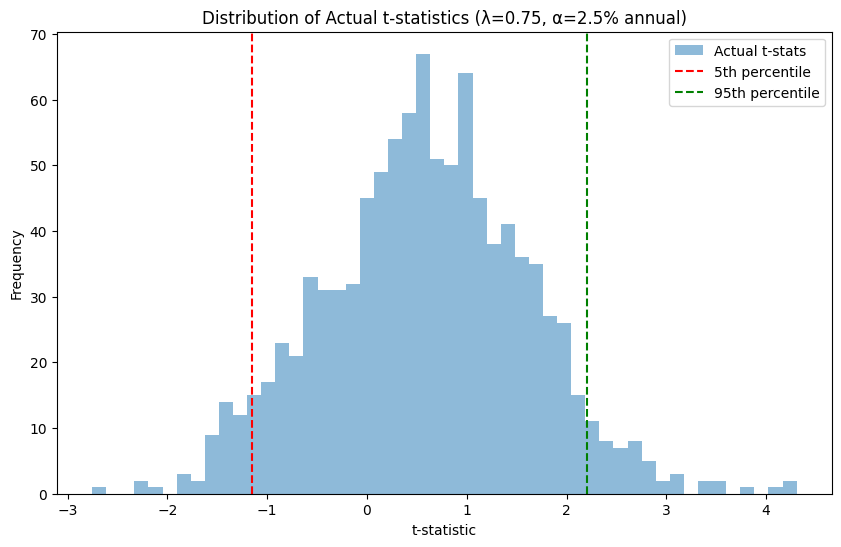

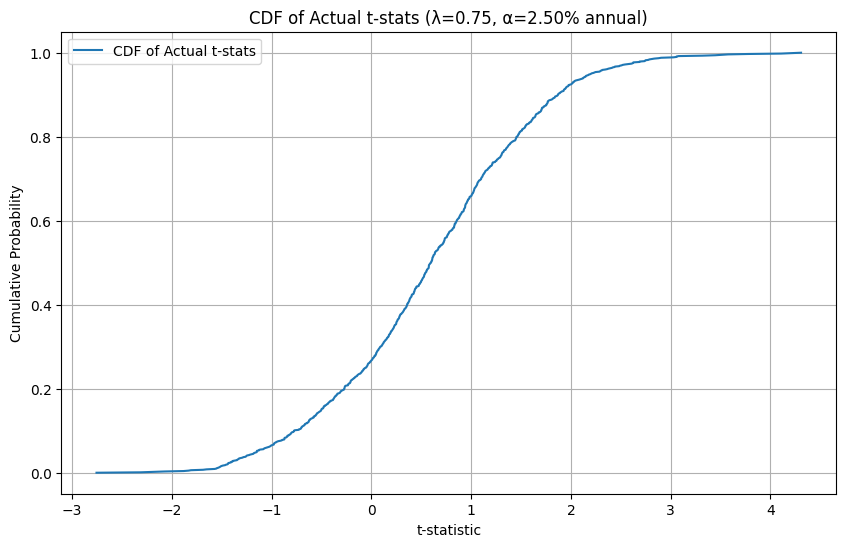

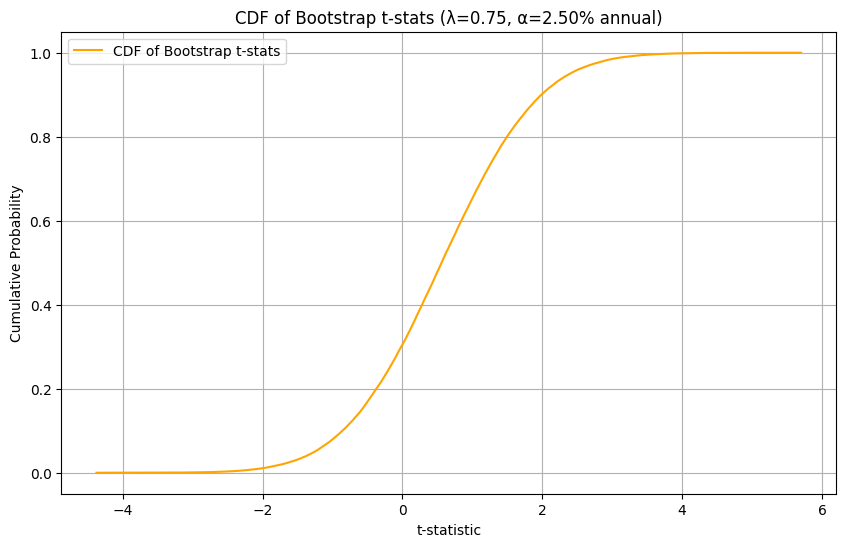

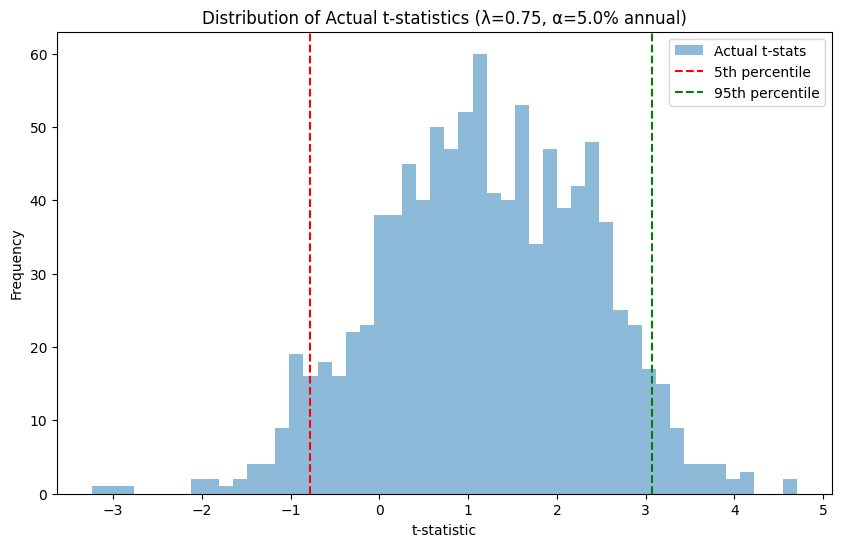

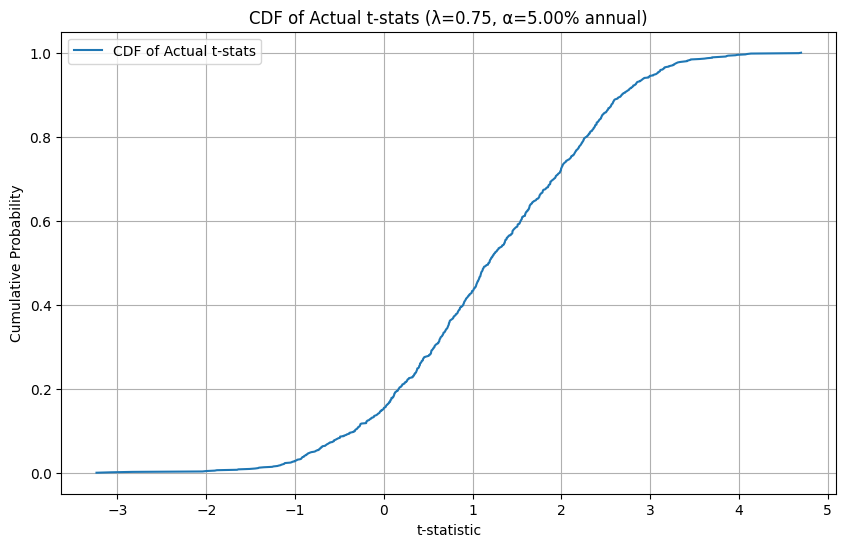

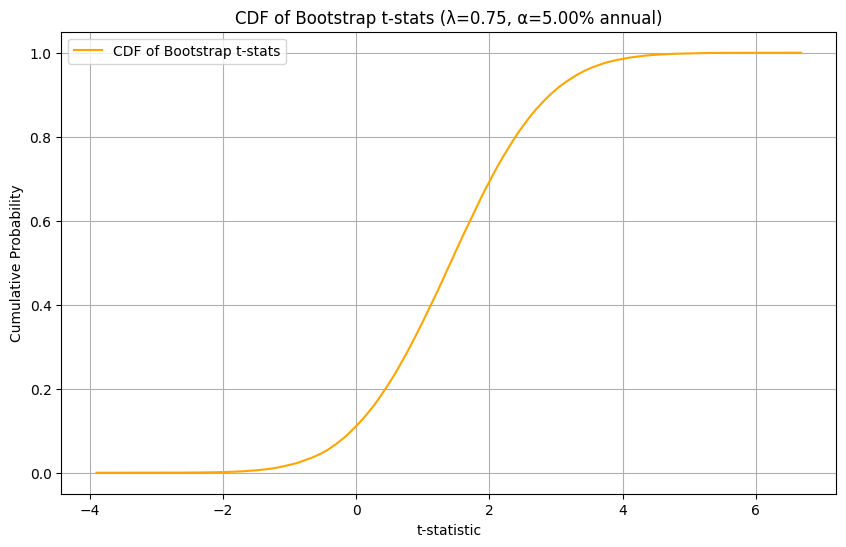

In [5]:
lambda_values = [0.1, 0.25, 0.5, 0.75]  
true_alphas_annual = [0.01, 0.025, 0.05]  
true_alphas = [alpha / 12 for alpha in true_alphas_annual] 

def simulate_fund_returns_with_skill(N, T, market_return_mean, market_return_sd, residual_sd, lambda_value, true_alpha):
    market_returns = np.random.normal(market_return_mean, market_return_sd, T)
    funds_returns = np.zeros((N, T))
    alphas = np.zeros(N)
    betas = np.zeros(N)
    t_stats = np.zeros(N)
    skilled_funds = np.random.choice(N, int(lambda_value * N), replace=False)  # Choose skilled funds

    for i in range(N):
        residuals = np.random.normal(0, residual_sd, T)
        alpha = true_alpha if i in skilled_funds else 0
        fund_returns = alpha + market_returns + residuals  # Fund returns with skill
        funds_returns[i, :] = fund_returns
        
        # Regression 
        X = sm.add_constant(market_returns)  # Adding a constant for alpha
        model = sm.OLS(fund_returns, X).fit()
        alphas[i] = model.params[0]
        betas[i] = model.params[1]
        t_stats[i] = model.tvalues[0]

    return alphas, betas, t_stats, funds_returns 


# Loop over lambda values and true alpha values
for lambda_value in lambda_values:
    for true_alpha in true_alphas:
        alphas, betas, t_stats, funds_returns = simulate_fund_returns_with_skill(
            N, T, market_return_mean, market_return_sd, residual_sd, lambda_value, true_alpha)

        bootstrap_t_stats = np.zeros((B, N))
        for b in range(B):
            for i in range(N):
                bootstrap_sample = np.random.choice(T, size=T, replace=True)
                bootstrap_fund_returns = funds_returns[i, bootstrap_sample]
                X_bootstrap = sm.add_constant(market_returns[bootstrap_sample])
                model_bootstrap = sm.OLS(bootstrap_fund_returns, X_bootstrap).fit()
                bootstrap_t_stats[b, i] = model_bootstrap.tvalues[0]

        plt.figure(figsize=(10, 6))
        plt.hist(t_stats, bins=50, alpha=0.5, label='Actual t-stats')
        plt.axvline(x=np.percentile(t_stats, 5), color='r', linestyle='--', label='5th percentile')
        plt.axvline(x=np.percentile(t_stats, 95), color='g', linestyle='--', label='95th percentile')
        plt.legend()
        plt.xlabel('t-statistic')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Actual t-statistics (λ={lambda_value}, α={true_alpha * 12:.1%} annual)')
        plt.show() 

        # Calculate the CDF of the actual t-statistics
        sorted_t_stats = np.sort(t_stats)
        cdf_actual = np.arange(1, N+1) / N
        
        # Calculate the CDFs for bootstrap samples
        sorted_bootstrap_t_stats = np.sort(bootstrap_t_stats.flatten())
        cdf_bootstrap = np.arange(1, B*N+1) / (B*N)

        # Plotting results for the actual t-statistics
        plt.figure(figsize=(10, 6))
        plt.plot(sorted_t_stats, cdf_actual, label='CDF of Actual t-stats')
        plt.title(f'CDF of Actual t-stats (λ={lambda_value}, α={true_alpha * 12:.2%} annual)')
        plt.xlabel('t-statistic')
        plt.ylabel('Cumulative Probability')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plotting results for the bootstrap t-statistics
        plt.figure(figsize=(10, 6))
        plt.plot(sorted_bootstrap_t_stats, cdf_bootstrap, label='CDF of Bootstrap t-stats', color='orange')
        plt.title(f'CDF of Bootstrap t-stats (λ={lambda_value}, α={true_alpha * 12:.2%} annual)')
        plt.xlabel('t-statistic')
        plt.ylabel('Cumulative Probability')
        plt.legend()
        plt.grid(True)
        plt.show() 